# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Homotopy-solver-for-Proximal-Denoising" data-toc-modified-id="Homotopy-solver-for-Proximal-Denoising-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Homotopy solver for Proximal Denoising</a></div><div class="lev2 toc-item"><a href="#Test-runs" data-toc-modified-id="Test-runs-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Test runs</a></div><div class="lev2 toc-item"><a href="#Function-definitions-and-cythonification" data-toc-modified-id="Function-definitions-and-cythonification-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Function definitions and cythonification</a></div><div class="lev2 toc-item"><a href="#Run-testError-on-PD-problem" data-toc-modified-id="Run-testError-on-PD-problem-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Run <code>testError</code> on PD problem</a></div><div class="lev2 toc-item"><a href="#Plot-results" data-toc-modified-id="Plot-results-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plot results</a></div><div class="lev2 toc-item"><a href="#Individual-vectors" data-toc-modified-id="Individual-vectors-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Individual vectors</a></div><div class="lev1 toc-item"><a href="#Approximate-Message-Passing-algorithm" data-toc-modified-id="Approximate-Message-Passing-algorithm-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Approximate Message Passing algorithm</a></div><div class="lev1 toc-item"><a href="#SPGL1" data-toc-modified-id="SPGL1-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SPGL1</a></div>

In [1]:
from datetime import datetime as dt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def softhr(y,lam):
    """
    softhr(y, lam) computes the soft-thresholding wrt lam of the vector y
    and its gradient evaluated at y:
        S(y; lam) = sgn(y) max(0, abs(y) - lam)
        Dj(S(y; lam)) = 1 if abs(yj) > lam else 0
    """
    # Returns:
    # - soft-thresholding of y wrt lam
    # - derivative of soft-thresholding wrt lam evaluated at y
    ythr = np.sign(y)*np.fmax(0, np.abs(y)-lam)
    return (ythr, (np.abs(y)>lam).astype(np.float64))

# Homotopy solver for Proximal Denoising

Given $\sigma > 0$ and $y \in \mathbb R^N$ with $y = x + \eta z$, we want to return $\lambda > 0$ such that
$$
f(\lambda) := \|T_\lambda (y) - y\|_2^2 = \sigma^2
$$

## Test runs

See note on run times below...

Pure python version
```python
range(1,4): 1 loop, best of 3: 5.58 s per loop  
range(1,5): 1 loop, best of 3: 50.4 s per loop
```
Cython version:
```python
range(1,4): 1 loop, best of 3: 4.26 s per loop  
range(1,5): 1 loop, best of 3: 38.9 s per loop
```

## Function definitions and cythonification

In [4]:
%load_ext Cython

In [5]:
%%cython

import numpy as np
cimport numpy as np
from numpy import dot
from libc.math cimport sqrt

DBL = np.double
ctypedef np.double_t DBL_C
INT = np.int
ctypedef np.int_t INT_C


def unsort(np.ndarray[DBL_C, ndim=1] increasingVector, np.ndarray[INT_C, ndim=1] sortOrder):
    cdef np.ndarray[DBL_C, ndim=1] unsortedVector
    cdef INT_C idx, orderedIdx
    unsortedVector = np.zeros(increasingVector.size)
    for idx, orderedIdx in enumerate(sortOrder):
        unsortedVector[orderedIdx] = increasingVector[idx]
    return unsortedVector

def HomPD(np.ndarray[DBL_C, ndim=1] y, sigmaSquared, **kwargs):
    """
    HomPD(np.ndarray[DBL_C, ndim=1] y, sigmaSquared, **kwargs):
    Input:
    sigmaSquared: variance
    y: assume y is already ravelled to an np vector!
    """
    cdef np.ndarray[DBL_C, ndim=1] lam, S, f, xHat
    cdef np.ndarray[INT_C, ndim=1] y_sgn, sortOrder
    returnLambda = kwargs.get('returnLambda', False)
    if sigmaSquared > dot(y.T, y):
        if returnLambda:
            return (np.zeros(y.size), np.abs(y).max())
        else:
            return np.zeros(y.size)
    y_shape = y.size # store shape before ravel
    y_sgn = np.sign(y).astype(np.int) # store sign for later
    y = np.abs(y) # absolute value
    sortOrder = np.argsort(y).astype(np.int) # store seq for ++ing order
    y = y[sortOrder] # sort y in ++ing order
    n = y.size # num elements in y

    lam = np.insert(y, 0, 0) # λ_j values
    S = np.zeros(lam.size) # S_j values
    f = np.zeros(lam.size) # f_j values

    for j in range(1,n+1):
        S[j] = S[j-1] + lam[j-1]**2 # previously killed
        f[j] = (n - (j-1))*lam[j]**2 + S[j] # still active
        if sigmaSquared < f[j]: # if σ^2 is in I_j = [f[j-1], f[j]]
            lam_star = np.sqrt((sigmaSquared - S[j])/(n - (j-1)))
            xHat = np.zeros(n)
            xHat[j-1:] = (y[j-1:] - lam_star) * y_sgn[sortOrder][j-1:]
            if returnLambda:
                return (unsort(xHat, sortOrder).reshape(y_shape), lam_star)
            else:
                return unsort(xHat, sortOrder).reshape(y_shape)
    raise Exception('Could not find interval in which sigmaSquared lies')

def testError_c(INT_C n, iters=10,
              sigmaSquared=None, 
              verbose=False):
    if sigmaSquared is None:
        sigmaSquared = n
    cdef DBL_C avgSqError
    cdef np.ndarray[DBL_C, ndim=1] x, y, z, e, xHat

    x = np.zeros(n)
    x[-1] = n
    avgSqError = 0
    for j in range(iters):
        z = np.random.randn(n)
        if sigmaSquared is 'sqNormZ':
            z_sqNorm = np.linalg.norm(z)**2
            sigmaSquared = z_sqNorm
            if verbose:
                print('||z||^2 = {}'.format(z_sqNorm))
        elif verbose:
            print('||z||^2 = {}'.format(np.linalg.norm(z)**2))
        y = x + z
        xHat = HomPD(y, sigmaSquared)
        e = xHat - x
        avgSqError += dot(e.T, e)
    avgSqError /= iters
    return avgSqError

## Run `testError` on PD problem

In [6]:
kmax = 4

In [7]:
n_vec = [10**j for j in range(1, kmax)]
testError_dimensionThreshold = np.zeros(len(n_vec))
testError_perfectThreshold = np.zeros(len(n_vec))
for j, n in enumerate(n_vec):
    print('Loop {}; length(x) = {}'.format(j+1,n))
    testError_dimensionThreshold[j] = testError_c(n, iters=1000)
    testError_perfectThreshold[j] = testError_c(n, iters=1000, sigmaSquared="sqNormZ")

Loop 1; length(x) = 10
Loop 2; length(x) = 100
Loop 3; length(x) = 1000


## Plot results

In [8]:
doHomPDSaveFig = 0
doHomPDSaveText = 0

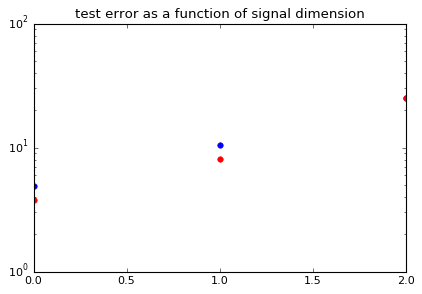

In [9]:
plt.plot(testError_dimensionThreshold, 'b.', markersize=10)
plt.plot(testError_perfectThreshold, 'r.', markersize=10)
plt.title('test error as a function of signal dimension')
plt.yscale('log');
if doHomPDSaveFig:
    plt.savefig('test-error-as-a-function-of-signal-dimension.svg')

In [10]:
if doHomPDSaveText:
    curDT = dt.now()
    np.savetxt('testError_perfectThreshold-dim-equals-pow_10_k-k_in_range_1_'+str(kmax)+'--'+curDT.ctime()+'.txt', testError_perfectThreshold)
    np.savetxt('testError_dimensionThreshold-dim-equals-pow_10_k-k_in_range_1_'+str(kmax)+'--'+curDT.ctime()+'.txt', testError_dimensionThreshold)

Note possible scaling is $n^{1/3} \log (n)$ where $n$ is the dimension of $x$. 

## Individual vectors

In [39]:
n = 10
x = np.zeros(n)
x[-1] = n

In [40]:
z = np.random.randn(n)
while np.dot(z, z) <= n + np.sqrt(n):
    z = np.random.randn(n)
print('baseline: {}'.format(n + np.sqrt(n)))
print('||z||^2 = {}'.format(np.dot(z,z)))

baseline: 13.16227766016838
||z||^2 = 17.61765803059383


In [70]:
asdf = np.random.RandomState()

In [ ]:
asdf.rand

In [56]:
y = x + z
xtilde = HomPD(y, n)
q = xtilde-y

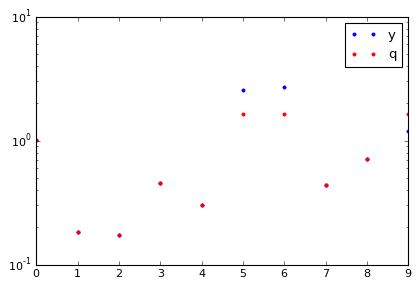

In [69]:
plt.plot(np.abs(z), '.b', label='y');
plt.plot(np.abs(q), '.r', label='q');
plt.legend(loc=0);
plt.yscale('log');

In [67]:
norms = [np.linalg.norm(v) for v in (z[:-1], q[:-1], (z+q)[:-1])]
normsSq = [nrm**2 for nrm in norms]
print('norm(z_TC): {}\nnorm(q_TC): {}\nnorm((z+q)_TC): {}'.format(*norms))
print('norm^2(z_TC): {}\nnorm^2(q_TC): {}\nnorm^2((z+q)_TC): {}'.format(*normsSq))

norm(z_TC): 4.023147374473169
norm(q_TC): 2.7138997434409022
norm((z+q)_TC): 1.4604316578035443
norm^2(z_TC): 16.185714796730352
norm^2(q_TC): 7.365251817448595
norm^2((z+q)_TC): 2.132860627114809


In [68]:
np.dot(z[:-1], q[:-1])

-10.709052993532067

In [66]:
np.linalg.norm(z[:-1])**2 - np.linalg.norm(q[:-1])**2

8.820462979281757

# Approximate Message Passing algorithm

In [ ]:
def AMP(y, A, **kwargs):
    import numpy as np
    x0 = kwargs.get('x0', np.zeros((A.shape[1],1)))
    funObj = kwargs.get('funObj', softhr)
    optTol = kwargs.get('optTol', 1e-4)
    maxIter = kwargs.get('maxIter', 500)
    lam = kwargs.get('lam', .1)
    
    xt = x0
    zt = y.copy()
    delta = A.shape[0]/A.shape[1] # aspect
    nIter = 1
    
    while True:
        x, g = funObj(np.dot(A.T, zt) + xt, lam)
        z = y - np.dot(A,x) + zt*np.mean(g)/delta
        
        optCond = abs(x-xt).max()
        if optCond < optTol:
            print('Optimality tolerance satisfied after %d iterations' % nIter)
            return x, z
        elif nIter > maxIter:
            print('Maximum number of iterations reached')
            return x
        else:
            nIter += 1
            xt = x
            zt = z
    return x, z

In [ ]:
N = 10000
s = 2
n = 100
eta = .01
x = np.array([[1e3 for _ in range(s)] + [0 for _ in range(N-s)]]).T

In [ ]:
A = np.random.randn(n,N)/np.sqrt(n)
z = np.random.randn(n,1)

In [ ]:
y = np.dot(A,x) + eta*z

In [ ]:
print('norm(x) = %5.4g\nnorm(y) = %5.4g' % (np.linalg.norm(x), np.linalg.norm(y)))

In [ ]:
%%prun
xstar, zstar = AMP(y,A, lam=400, maxIter=500)

In [ ]:
(x-xstar).var()

# SPGL1

In [14]:
sys.path.append('/Users/berkas/Dropbox/school/phd/research/code/SPGL1_python_port/')

In [24]:
from spgl1 import spgl1
from spgl1 import spgSetParms

In [129]:
import json, codecs

In [96]:
def pdmse_1(N, theta=None, **kwargs):
    s = 1
    eta = kwargs.get('eta', 1)
    x = np.array([N for _ in range(s)] + [0 for _ in range(N-s)])
    z = np.random.randn(N)
    if theta is None:
        theta = np.sqrt(N)
    elif theta is 'sqNormZ':
        theta = np.linalg.norm(z)
    elif isinstance(theta, 'str'):
        raise ValueError('theta must be numeric or equal to \'sqNormZ\'.')
    y = x + eta*z
    A = np.eye(N)
    xstar, r, g, info = spgl1(A, y, sigma=theta)
    h = x - xstar
    return np.dot(h,h)

def pdmse(N, theta=None, **kwargs):
    iters = kwargs.pop('iters', 10)
    return np.mean([pdmse_1(N, theta, **kwargs) for _ in range(iters)])

def pdmse_batch(logNmax=5, theta=None, **kwargs):
    outerIters = kwargs.pop('outerIters', 100)
    Nvec = [10**j for j in range(1, logNmax+1)]
    retmat = np.zeros((logNmax, outerIters))
    for i,N in enumerate(Nvec):
        for j in range(outerIters):
            retmat[i,j] = pdmse(N, theta, **kwargs)
    return retmat

In [140]:
def jsonWriteDict(filename, obj):
    import json, codecs
    for key, value in obj.items():
        if isinstance(obj[key], np.ndarray):
            obj[key] = value.tolist()
    try:
        with codecs.open(filename, 'w', encoding='utf-8') as fp:
            json.dump(obj, fp, separators=(',', ':'), indent=4, sort_keys=True)
    except Exception as e:
        print(e)
        print("Unexpected error:", sys.exc_info()[0])
        raise

In [120]:
pdmse_mat = {'N': pdmse_batch(2), 
             'sqNormZ': pdmse_batch(2, theta='sqNormZ')}

In [141]:
jsonWriteDict('test_json.json', pdmse_mat)

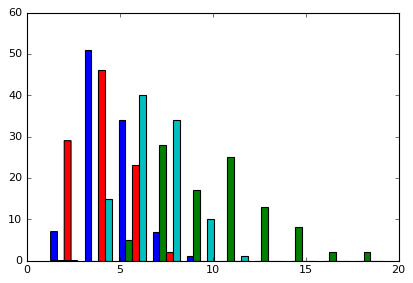

In [115]:
plt.hist(np.vstack((pdmse_mat_N, pdmse_mat_zsq)).T, stacked=False);